In [1]:
import pandas as pd          # импортирование библиотек и чтение данных из файла
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

df = pd.read_csv('data.txt', skiprows=0, sep=';')
df.shape

(96605, 30)

In [2]:
df.head() # ознакомление с данными

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,1,1,1,1,39,1,Москва,51,12,...,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
1,TRAIN,2,1,1,1,50,5,Москва,35,7,...,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
2,TRAIN,3,1,1,1,52,6,Москва,41,6,...,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
3,TRAIN,4,1,1,1,50,5,Москва,36,12,...,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
4,TRAIN,5,1,1,0,52,6,Санкт-Петербург,42,5,...,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


In [3]:
df.dtypes # ознакомление с данными

DATA_TYPE                         object
POLICY_ID                          int64
POLICY_BEGIN_MONTH                 int64
POLICY_END_MONTH                   int64
POLICY_IS_RENEWED                  int64
POLICY_SALES_CHANNEL               int64
POLICY_SALES_CHANNEL_GROUP         int64
POLICY_BRANCH                     object
POLICY_MIN_AGE                     int64
POLICY_MIN_DRIVING_EXPERIENCE      int64
VEHICLE_MAKE                      object
VEHICLE_MODEL                     object
VEHICLE_ENGINE_POWER             float64
VEHICLE_IN_CREDIT                  int64
VEHICLE_SUM_INSURED              float64
POLICY_INTERMEDIARY               object
INSURER_GENDER                    object
POLICY_CLM_N                      object
POLICY_CLM_GLT_N                  object
POLICY_PRV_CLM_N                  object
POLICY_PRV_CLM_GLT_N              object
CLIENT_HAS_DAGO                    int64
CLIENT_HAS_OSAGO                   int64
POLICY_COURT_SIGN                  int64
CLAIM_AVG_ACC_ST

In [4]:
df['POLICY_BRANCH']=df['POLICY_BRANCH'].astype('category').cat.codes # Некоторые колонки имеют тип данных object
df['VEHICLE_MAKE']=df['VEHICLE_MAKE'].astype('category').cat.codes   # для построение корреляционной матрицы необходимо иметь
df['VEHICLE_MODEL']=df['VEHICLE_MODEL'].astype('category').cat.codes # числовой или логический тип данных 
df['INSURER_GENDER']=df['INSURER_GENDER'].astype('category').cat.codes
df['CLIENT_REGISTRATION_REGION']=df['CLIENT_REGISTRATION_REGION'].astype('category').cat.codes
df['POLICY_INTERMEDIARY']=df['POLICY_INTERMEDIARY'].astype('category').cat.codes
df['POLICY_CLM_N']=df['POLICY_CLM_N'].astype('category').cat.codes
df['POLICY_CLM_GLT_N']=df['POLICY_CLM_GLT_N'].astype('category').cat.codes
df['POLICY_PRV_CLM_N']=df['POLICY_PRV_CLM_N'].astype('category').cat.codes
df['POLICY_PRV_CLM_GLT_N']=df['POLICY_PRV_CLM_GLT_N'].astype('category').cat.codes
df.loc[df.POLICY_YEARS_RENEWED_N == 'N', 'POLICY_YEARS_RENEWED_N'] = 0       
df['POLICY_YEARS_RENEWED_N']=df['POLICY_YEARS_RENEWED_N'].astype('int64')

In [5]:
# в случае с числовыми данными, имеющими широкий интервал с множеством вариаций, 
# делим данные на 50 квантилей и присваиваем номер
def pct_rank_qcut(series, n):                                          
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)
df["POLICY_MIN_AGE"] = pct_rank_qcut(df.POLICY_MIN_AGE, 50).astype('int64')
df["POLICY_MIN_DRIVING_EXPERIENCE"] = pct_rank_qcut(df.POLICY_MIN_DRIVING_EXPERIENCE, 50).astype('int64')
df["VEHICLE_ENGINE_POWER"] = pct_rank_qcut(df.VEHICLE_ENGINE_POWER, 50).astype('int64')
df["VEHICLE_SUM_INSURED"] = pct_rank_qcut(df.VEHICLE_SUM_INSURED, 50).astype('int64')
df["POLICY_PRICE_CHANGE"] = pct_rank_qcut(df.POLICY_PRICE_CHANGE, 50).astype('int64')
df["CLAIM_AVG_ACC_ST_PRD"] = pct_rank_qcut(df.CLAIM_AVG_ACC_ST_PRD, 50).astype('int64')
df["POLICY_DEDUCT_VALUE"] = pct_rank_qcut(df.POLICY_DEDUCT_VALUE, 50).astype('int64')

In [6]:
df_tr = df[df['DATA_TYPE']=='TRAIN']    # отбираем данные с заполненным таргетом (колонка POLICY_IS_RENEWED)
cols = list(df_tr.columns)              # перемещаем предсказываемую колонку на нулевую позицию
cols = [cols[4]] + cols[0:4]+cols[5:30]
df_tr = df_tr[cols]

In [7]:
df_tr.nunique()

POLICY_IS_RENEWED                    2
DATA_TYPE                            1
POLICY_ID                        77407
POLICY_BEGIN_MONTH                  12
POLICY_END_MONTH                    12
POLICY_SALES_CHANNEL                63
POLICY_SALES_CHANNEL_GROUP           8
POLICY_BRANCH                        2
POLICY_MIN_AGE                      38
POLICY_MIN_DRIVING_EXPERIENCE       32
VEHICLE_MAKE                        80
VEHICLE_MODEL                      525
VEHICLE_ENGINE_POWER                44
VEHICLE_IN_CREDIT                    2
VEHICLE_SUM_INSURED                 50
POLICY_INTERMEDIARY               1333
INSURER_GENDER                       2
POLICY_CLM_N                         7
POLICY_CLM_GLT_N                     7
POLICY_PRV_CLM_N                     7
POLICY_PRV_CLM_GLT_N                 7
CLIENT_HAS_DAGO                      2
CLIENT_HAS_OSAGO                     2
POLICY_COURT_SIGN                    2
CLAIM_AVG_ACC_ST_PRD                13
POLICY_HAS_COMPLAINTS    

In [8]:
# удаляем: id (относится к конкретному полису), DATA_TYPE (только TRAIN)
df_tr = df_tr.drop(["POLICY_ID", 'DATA_TYPE'], axis = 1) 

In [9]:
df_tr.dtypes

POLICY_IS_RENEWED                int64
POLICY_BEGIN_MONTH               int64
POLICY_END_MONTH                 int64
POLICY_SALES_CHANNEL             int64
POLICY_SALES_CHANNEL_GROUP       int64
POLICY_BRANCH                     int8
POLICY_MIN_AGE                   int64
POLICY_MIN_DRIVING_EXPERIENCE    int64
VEHICLE_MAKE                      int8
VEHICLE_MODEL                    int16
VEHICLE_ENGINE_POWER             int64
VEHICLE_IN_CREDIT                int64
VEHICLE_SUM_INSURED              int64
POLICY_INTERMEDIARY              int16
INSURER_GENDER                    int8
POLICY_CLM_N                      int8
POLICY_CLM_GLT_N                  int8
POLICY_PRV_CLM_N                  int8
POLICY_PRV_CLM_GLT_N              int8
CLIENT_HAS_DAGO                  int64
CLIENT_HAS_OSAGO                 int64
POLICY_COURT_SIGN                int64
CLAIM_AVG_ACC_ST_PRD             int64
POLICY_HAS_COMPLAINTS            int64
POLICY_YEARS_RENEWED_N           int64
POLICY_DEDUCT_VALUE      

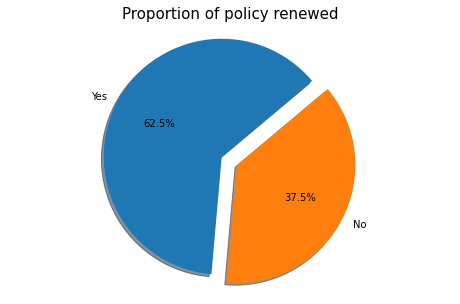

In [10]:
# смотрим пропорций переоформления полиса
# наблюдается баланс классов
labels = 'Yes', 'No'      
sizes = [df_tr.POLICY_IS_RENEWED[df_tr["POLICY_IS_RENEWED"]==1].count(), df_tr.POLICY_IS_RENEWED[df_tr["POLICY_IS_RENEWED"]==0].count()]
explode = (0, 0.15)
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=40)
ax1.axis('equal')
plt.title("Proportion of policy renewed", size = 15)
plt.show()

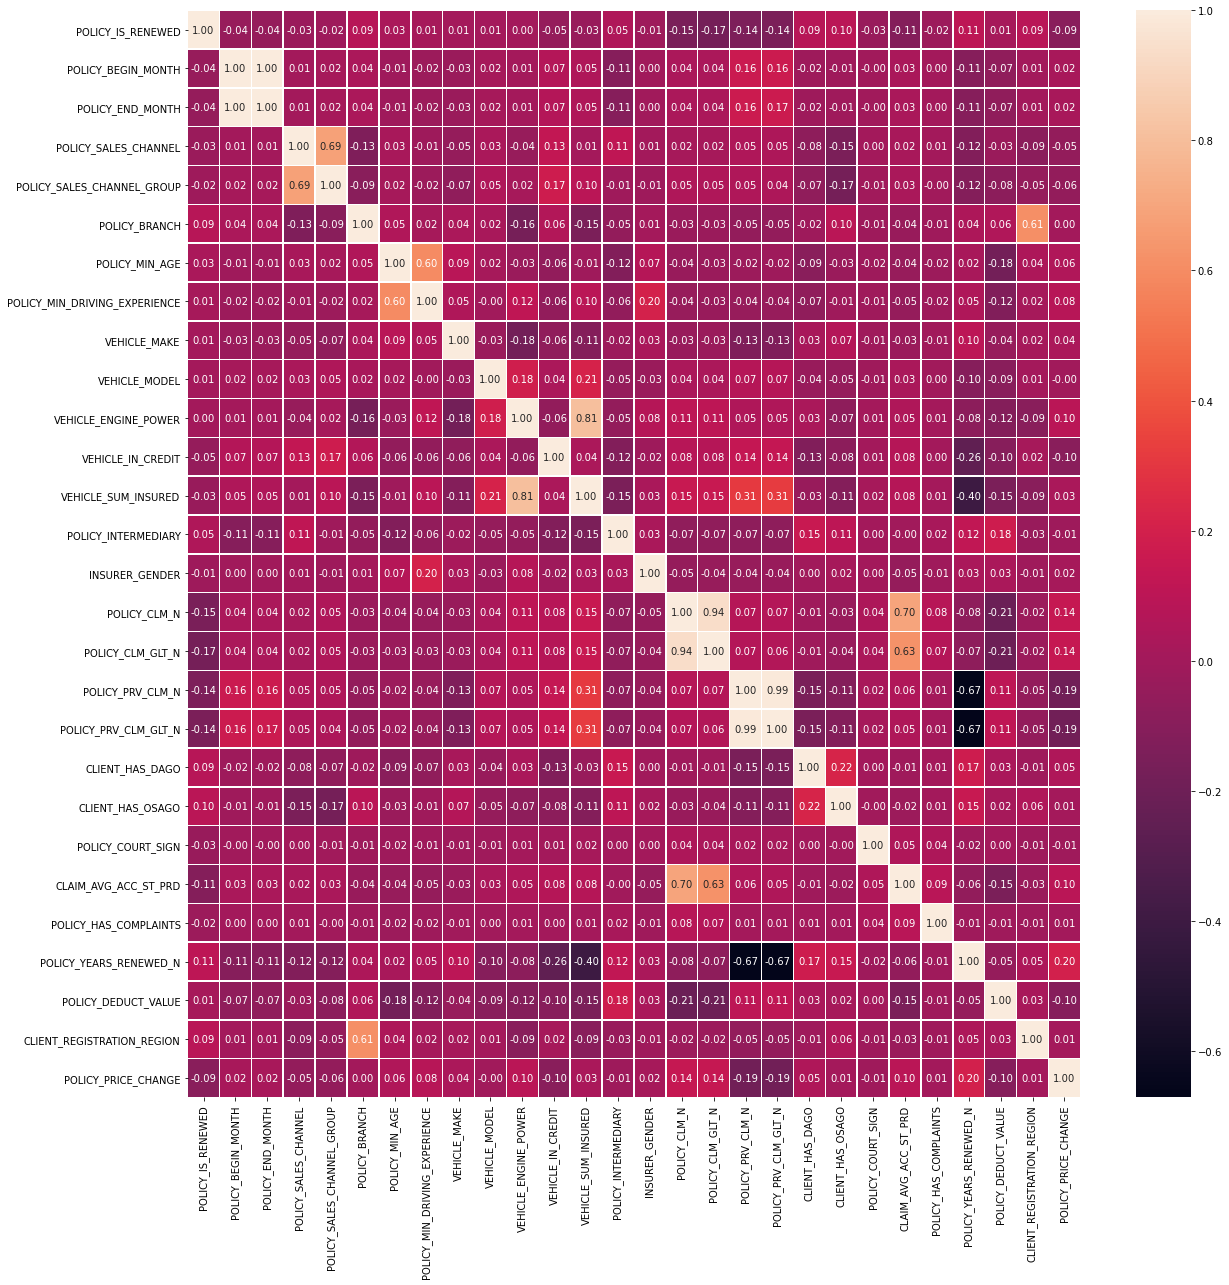

In [11]:
# строим матрицу корреляции, отбираем признаки, коррелирующие с колонкой POLICY_IS_RENEWED
# чем выше абсолютное значение, тем выше корреляция
plt.figure(figsize = (20,20))  
sns.heatmap((df_tr.loc[:, :]).corr(), annot=True,linewidths=.5,fmt = ".2f");

In [12]:
df_tr = df_tr[['POLICY_IS_RENEWED','POLICY_BEGIN_MONTH','POLICY_END_MONTH','POLICY_SALES_CHANNEL','POLICY_BRANCH','POLICY_MIN_AGE','VEHICLE_IN_CREDIT','VEHICLE_SUM_INSURED','POLICY_INTERMEDIARY','POLICY_CLM_N','POLICY_CLM_GLT_N','POLICY_PRV_CLM_N','POLICY_PRV_CLM_GLT_N',\
               'CLIENT_HAS_DAGO','CLIENT_HAS_OSAGO','POLICY_COURT_SIGN','CLAIM_AVG_ACC_ST_PRD', 'POLICY_YEARS_RENEWED_N','CLIENT_REGISTRATION_REGION', 'POLICY_PRICE_CHANGE']]

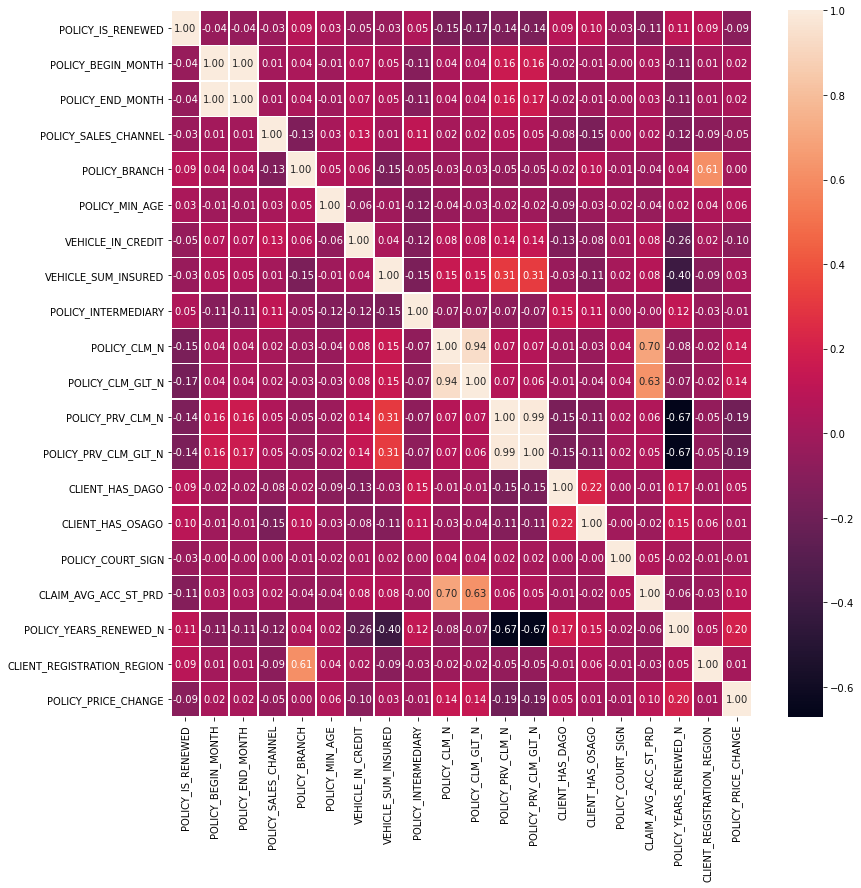

In [13]:
# исключаем признаки, которые коррелируют между собой Например POLICY_CLM_N и POLICY_CLM_GLT_N
# из двух выбираем POLICY_CLM_GLT_N, так как у него выше корреляция с таргетом
plt.figure(figsize = (13,13))  
sns.heatmap((df_tr.loc[:, :]).corr(), annot=True,linewidths=.5,fmt = ".2f");

In [14]:
df_tr = df_tr[['POLICY_IS_RENEWED','POLICY_BEGIN_MONTH','POLICY_SALES_CHANNEL','POLICY_BRANCH','POLICY_MIN_AGE','VEHICLE_IN_CREDIT','VEHICLE_SUM_INSURED','POLICY_INTERMEDIARY','POLICY_CLM_GLT_N','POLICY_PRV_CLM_GLT_N',\
               'CLIENT_HAS_DAGO','CLIENT_HAS_OSAGO','POLICY_COURT_SIGN', 'POLICY_YEARS_RENEWED_N', 'CLIENT_REGISTRATION_REGION', 'POLICY_PRICE_CHANGE']]

In [15]:
# делим на тренировочную и тестовую выборки
df_train = df_tr.sample(frac=0.7, random_state=200)
df_test = df_tr.drop(df_train.index)
print('Тренировочная выборка: ',len(df_train))
print('Тестовая выборка: ',len(df_test))

Тренировочная выборка:  54185
Тестовая выборка:  23222


In [16]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_train.head()

,POLICY_IS_RENEWED,POLICY_BEGIN_MONTH,POLICY_SALES_CHANNEL,POLICY_BRANCH,POLICY_MIN_AGE,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,POLICY_INTERMEDIARY,POLICY_CLM_GLT_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,POLICY_YEARS_RENEWED_N,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
56749,0,8,52,0,27,1,32,658,5,3,0,0,0,1,42,50
13952,1,10,52,1,30,1,6,108,0,0,0,0,0,1,58,26
33309,0,8,53,0,11,0,28,598,0,0,1,0,0,2,42,39
54211,1,5,52,1,45,0,1,1405,0,0,1,1,0,4,58,39
92504,1,10,50,0,7,0,31,1405,0,6,0,1,0,0,41,1


In [17]:
df_train.dtypes

POLICY_IS_RENEWED             int64
POLICY_BEGIN_MONTH            int64
POLICY_SALES_CHANNEL          int64
POLICY_BRANCH                  int8
POLICY_MIN_AGE                int64
VEHICLE_IN_CREDIT             int64
VEHICLE_SUM_INSURED           int64
POLICY_INTERMEDIARY           int16
POLICY_CLM_GLT_N               int8
POLICY_PRV_CLM_GLT_N           int8
CLIENT_HAS_DAGO               int64
CLIENT_HAS_OSAGO              int64
POLICY_COURT_SIGN             int64
POLICY_YEARS_RENEWED_N        int64
CLIENT_REGISTRATION_REGION     int8
POLICY_PRICE_CHANGE           int64
dtype: object

In [18]:
def best_model(model): 
    print('Оценка модели: ', model.best_score_)    
    print('Гиперпараметры: ', model.best_params_)

In [19]:
# настраиваем гиперпараметры на тренировочной выборке, используя кросс-валидацию
# используется метод градиентного бустинга
param_grid = {'max_depth': [5, 6, 7, 8],'gamma': [0.01, 0.001],'min_child_weight':[1,3], 'learning_rate': [0.1, 0.2], 'n_estimators':[50, 100]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
xgb_grid.fit(df_train.loc[:, df_train.columns != 'POLICY_IS_RENEWED'], df_train.POLICY_IS_RENEWED)
best_model(xgb_grid)

Оценка модели:  0.7161206976100397
Гиперпараметры:  {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100}


In [31]:
# задав, полученные гиперпараметры, обучаем модель на тренировочной выборке
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=1, missing=None, n_estimators=100,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1)
XGB.fit(df_train.loc[:, df_train.columns != 'POLICY_IS_RENEWED'],df_train.POLICY_IS_RENEWED)

XGBClassifier(gamma=0.01, max_depth=7, silent=True)

In [32]:
# результат на тренировочной выборке
print(classification_report(df_train.POLICY_IS_RENEWED,  XGB.predict(df_train.loc[:, df_train.columns != 'POLICY_IS_RENEWED'])))

              precision    recall  f1-score   support

           0       0.77      0.49      0.60     20407
           1       0.75      0.91      0.82     33778

    accuracy                           0.75     54185
   macro avg       0.76      0.70      0.71     54185
weighted avg       0.75      0.75      0.74     54185



In [33]:
df_test.head(5)

,POLICY_IS_RENEWED,POLICY_BEGIN_MONTH,POLICY_SALES_CHANNEL,POLICY_BRANCH,POLICY_MIN_AGE,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,POLICY_INTERMEDIARY,POLICY_CLM_GLT_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,POLICY_YEARS_RENEWED_N,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
3,1,1,50,0,16,0,23,1405,0,0,1,1,0,6,41,39
4,0,1,52,1,27,0,16,486,0,6,0,0,0,0,36,46
17,1,1,52,0,44,1,17,1307,0,1,0,0,0,3,42,12
20,1,2,53,1,16,0,39,830,0,0,0,0,0,1,58,47
27,0,1,50,1,7,0,5,1405,0,0,1,1,0,6,58,39


In [34]:
# результат на тестовой выборке. Видим, что модель не переобучилась
print(classification_report(df_test.POLICY_IS_RENEWED,  XGB.predict(df_test.loc[:, df_test.columns != 'POLICY_IS_RENEWED'])))

              precision    recall  f1-score   support

           0       0.68      0.44      0.54      8624
           1       0.73      0.88      0.80     14598

    accuracy                           0.72     23222
   macro avg       0.70      0.66      0.67     23222
weighted avg       0.71      0.72      0.70     23222



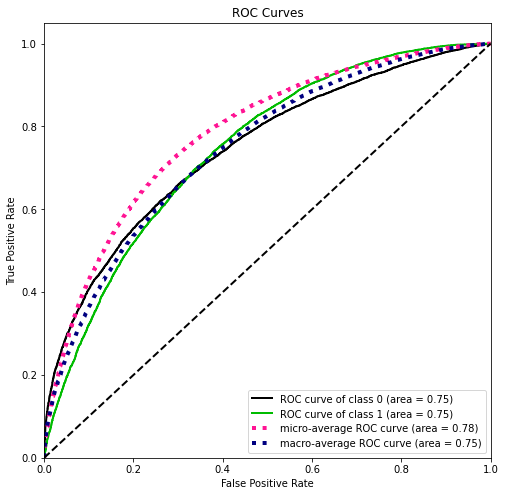

In [35]:
# наблюдаем баланс между классами 0  и 1
y_pred_proba = XGB.predict_proba(df_test.loc[:, df_test.columns != 'POLICY_IS_RENEWED'])
skplt.metrics.plot_roc_curve(df_test.POLICY_IS_RENEWED, y_pred_proba, figsize=(8,8))
plt.show()

In [36]:
# отбираем признаки для предсказательной выборки
df_te = df[df['DATA_TYPE']=='TEST ']  
df_te = df_te[['POLICY_BEGIN_MONTH','POLICY_SALES_CHANNEL','POLICY_BRANCH','POLICY_MIN_AGE','VEHICLE_IN_CREDIT','VEHICLE_SUM_INSURED','POLICY_INTERMEDIARY','POLICY_CLM_GLT_N','POLICY_PRV_CLM_GLT_N',\
               'CLIENT_HAS_DAGO','CLIENT_HAS_OSAGO','POLICY_COURT_SIGN', 'POLICY_YEARS_RENEWED_N', 'CLIENT_REGISTRATION_REGION', 'POLICY_PRICE_CHANGE']]
df_te.head(5)

,POLICY_BEGIN_MONTH,POLICY_SALES_CHANNEL,POLICY_BRANCH,POLICY_MIN_AGE,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,POLICY_INTERMEDIARY,POLICY_CLM_GLT_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,POLICY_YEARS_RENEWED_N,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
9,2,53,1,44,0,9,545,0,0,0,1,0,1,58,20
11,1,53,0,41,1,42,248,0,0,0,0,0,1,41,43
12,1,54,0,6,0,36,687,2,0,1,1,0,1,41,9
21,1,52,1,48,0,14,868,3,0,0,0,0,3,36,49
36,12,1,1,16,0,8,906,0,0,1,1,0,7,58,22


In [37]:
# прогноз переоформления полиса
y_pred = XGB.predict(df_te)
df_pred = pd.DataFrame({'POLICY_IS_RENEWED':y_pred})
print(df_pred)

       POLICY_IS_RENEWED
0                      1
1                      1
2                      1
3                      0
4                      1
...                  ...
19193                  1
19194                  0
19195                  1
19196                  1
19197                  1

[19198 rows x 1 columns]


In [38]:
# вероятность переоформления полиса
y_proba = XGB.predict_proba(df_te)
df_pred_porb = pd.DataFrame({'POLICY_IS_RENEWED_PROBABILITY':y_proba[:,1]})
print(df_pred_porb)

       POLICY_IS_RENEWED_PROBABILITY
0                           0.892989
1                           0.688033
2                           0.625025
3                           0.423134
4                           0.822190
...                              ...
19193                       0.766693
19194                       0.237060
19195                       0.904156
19196                       0.668636
19197                       0.787227

[19198 rows x 1 columns]


In [39]:
# id полисов
df_result = df.loc[df["DATA_TYPE"] =='TEST ', ["POLICY_ID"]]
df_result = df_result.reset_index(drop=True)
df_result

,POLICY_ID
0,10
1,12
2,13
3,22
4,37
...,...
19193,96574
19194,96577
19195,96586
19196,96595


In [40]:
# результат
df_result = pd.concat([df_result, df_pred, df_pred_porb], axis=1)
df_result

,POLICY_ID,POLICY_IS_RENEWED,POLICY_IS_RENEWED_PROBABILITY
0,10,1,0.892989
1,12,1,0.688033
2,13,1,0.625025
3,22,0,0.423134
4,37,1,0.822190
...,...,...,...
19193,96574,1,0.766693
19194,96577,0,0.237060
19195,96586,1,0.904156
19196,96595,1,0.668636


In [41]:
#df_result.to_csv('Result.csv')

In [ ]:
# метод ближайших соседей (KNN) дал результат хуже, чем XGB. 
# дополнительно можно проверить случайным лесом (Random Forest)